model.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

<ipython-input-1-ac573dfcf8f1>:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(state_dict_path, map_location=device))


Loaded model state dict from /kaggle/input/epass-imagee/pytorch/default/1/epass_model_state_dict.pth
Validation Loss: 0.8606
Validation Accuracy (Top-1): 0.7839
Validation Top-5 Accuracy: 0.9318
Validation Macro F1 Score: 0.7853
Validation AUC: 0.9956
Confusion Matrix shape: (200, 200)

Classification Report:
               precision    recall  f1-score   support

           0     0.8727    0.9600    0.9143        50
           1     0.8846    0.9200    0.9020        50
           2     0.7551    0.7400    0.7475        50
           3     0.6538    0.6800    0.6667        50
           4     0.8571    0.7200    0.7826        50
           5     0.8293    0.6800    0.7473        50
           6     0.8909    0.9800    0.9333        50
           7     0.8627    0.8800    0.8713        50
           8     0.9545    0.8400    0.8936        50
           9     0.9412    0.6400    0.7619        50
          10     0.9487    0.7400    0.8315        50
          11     0.8364    0.9200    0.

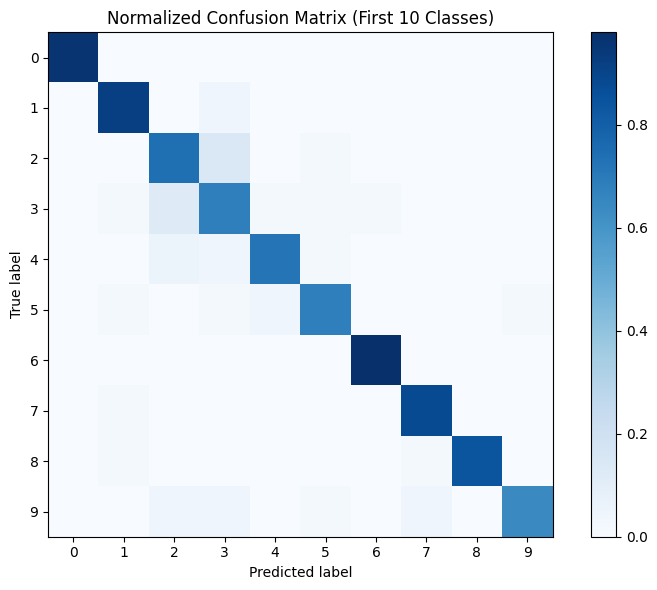

Loaded metrics history from /kaggle/input/metroo/metrics_history.json

--- Metrics History Summary ---
Total Epochs: 5
Best Train Loss: 1.0547 (Epoch 5)
Best Val Loss: 0.8606 (Epoch 5)
Best Train Accuracy: 0.7426 (Epoch 5)
Best Val Accuracy: 0.7839 (Epoch 5)
Best Val Macro F1: 0.7853 (Epoch 5)
Best Val AUC: 0.9960 (Epoch 3)


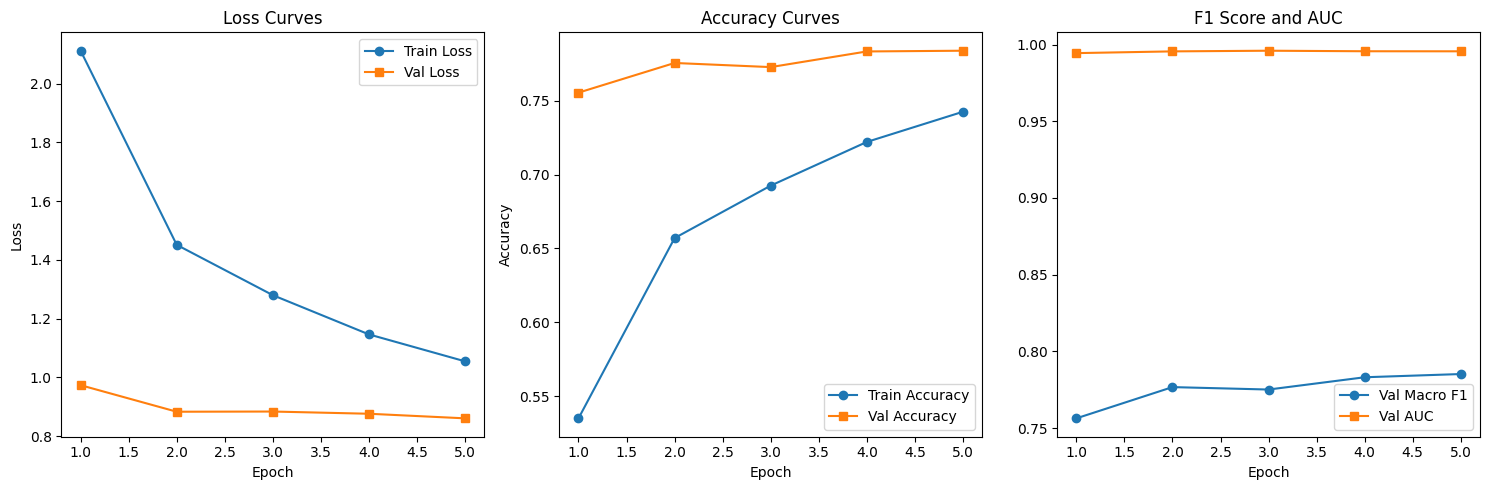

In [1]:
import os
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import timm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, cohen_kappa_score
from sklearn.preprocessing import label_binarize

###########################
# Settings and Parameters #
###########################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 200
batch_size = 64

# Mean and std for normalization (Tiny ImageNet)
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

##############################
# Dataset Preparation (Val)  #
##############################

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Directory paths (update if necessary)
dataset_dir = "/kaggle/input/tiny-imagenet/tiny-imagenet-200"  # change as needed
val_dir = os.path.join(dataset_dir, "val")
train_dir = os.path.join(dataset_dir, "train")

# Load validation set with ImageFolder
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

# Read validation annotations file to fix labels
val_ann_file = os.path.join(val_dir, "val_annotations.txt")
val_label_map = {}
with open(val_ann_file, "r") as f:
    for line in f:
        parts = line.strip().split("\t")
        file_name, label_id = parts[0], parts[1]
        val_label_map[file_name] = label_id

# To get the correct index mapping, load the training dataset
train_dataset = datasets.ImageFolder(train_dir, transform=val_transform)
label_ids = {folder: idx for idx, folder in enumerate(train_dataset.classes)}

# Update each validation sample so that its label index matches training mapping
for i in range(len(val_dataset.imgs)):
    file_path, _ = val_dataset.imgs[i]
    file_name = os.path.basename(file_path)
    true_label_id = val_label_map[file_name]
    val_dataset.imgs[i] = (file_path, label_ids[true_label_id])

# Create DataLoader for validation set
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

###############################################
# Model Definition and Loading (EPASS Model)  #
###############################################

class EPASSModel(nn.Module):
    def __init__(self, backbone, num_classes, feature_dim, projector_dim=256, num_projectors=3):
        super(EPASSModel, self).__init__()
        self.backbone = backbone  # Pretrained feature extractor
        self.num_projectors = num_projectors
        # Create an ensemble of projector heads
        self.projectors = nn.ModuleList([
            nn.Sequential(
                nn.Linear(feature_dim, projector_dim),
                nn.ReLU(inplace=True),
                nn.Linear(projector_dim, num_classes)
            ) for _ in range(num_projectors)
        ])
    
    def forward(self, x):
        features = self.backbone(x)  # Expected shape: [B, feature_dim]
        outputs = [proj(features) for proj in self.projectors]
        ensemble_output = torch.mean(torch.stack(outputs, dim=0), dim=0)
        return ensemble_output

# Load pretrained ConvNeXt-Small from timm (num_classes=0 to output features)
convnext = timm.create_model('convnext_small', pretrained=True, num_classes=0)
convnext.to(device)
convnext.eval()

feature_dim = 768  # ConvNeXt-Small outputs 768-dimensional features

# Re-create EPASS model and load the saved state dictionary
model = EPASSModel(convnext, num_classes=num_classes, feature_dim=feature_dim, projector_dim=256, num_projectors=3)
model.to(device)
state_dict_path = "/kaggle/input/epass-imagee/pytorch/default/1/epass_model_state_dict.pth"
if os.path.exists(state_dict_path):
    model.load_state_dict(torch.load(state_dict_path, map_location=device))
    print("Loaded model state dict from", state_dict_path)
else:
    print("Model state dict not found!")

model.eval()

####################################################
# Evaluation Functions: Metrics and Top-5 Accuracy #
####################################################

def evaluate_metrics(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_probs = []
    all_true = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    avg_loss = running_loss / len(dataloader.dataset)
    acc = accuracy_score(all_true, all_preds)
    f1 = f1_score(all_true, all_preds, average='macro')
    unique_classes = np.unique(all_true)
    true_binarized = label_binarize(all_true, classes=unique_classes)
    auc = roc_auc_score(true_binarized, np.array(all_probs), multi_class='ovr')
    return avg_loss, acc, f1, auc, all_true, all_preds

def evaluate_top5_accuracy(model, dataloader, device):
    model.eval()
    top5_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            top5 = torch.topk(outputs, k=5, dim=1).indices  # shape [B, 5]
            # Check if true label is among the top-5 predictions
            for i, label in enumerate(labels):
                if label in top5[i]:
                    top5_correct += 1
            total += images.size(0)
    return top5_correct / total

criterion = nn.CrossEntropyLoss()

# Evaluate on validation data
val_loss, val_acc, val_f1, val_auc, all_true, all_preds = evaluate_metrics(model, val_loader, criterion, device)
top5_acc = evaluate_top5_accuracy(model, val_loader, device)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy (Top-1): {val_acc:.4f}")
print(f"Validation Top-5 Accuracy: {top5_acc:.4f}")
print(f"Validation Macro F1 Score: {val_f1:.4f}")
print(f"Validation AUC: {val_auc:.4f}")

###############################################
# Additional Evaluation Statistics            #
###############################################

# Compute confusion matrix
cm = confusion_matrix(all_true, all_preds)
print("Confusion Matrix shape:", cm.shape)

# Print full classification report
report = classification_report(all_true, all_preds, digits=4)
print("\nClassification Report:\n", report)

# Compute Cohen's Kappa Score
kappa = cohen_kappa_score(all_true, all_preds)
print(f"Cohen's Kappa: {kappa:.4f}")

# Optionally, plot a normalized confusion matrix for the first 10 classes
subset = 10  # Adjust this value to display a subset for readability
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
plt.imshow(cm_normalized[:subset, :subset], interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix (First 10 Classes)")
plt.colorbar()
tick_marks = np.arange(subset)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

#########################################
# Metrics History: Load and Summarize   #
#########################################

metrics_history_file = "/kaggle/input/metroo/metrics_history.json"
if os.path.exists(metrics_history_file):
    with open(metrics_history_file, "r") as f:
        metrics_history = json.load(f)
    print("Loaded metrics history from", metrics_history_file)
else:
    print("Metrics history file not found!")
    metrics_history = {}

# Print summary statistics from history
if metrics_history:
    epochs = np.array(metrics_history["epoch"])
    train_loss = np.array(metrics_history["train_loss"])
    val_loss_hist = np.array(metrics_history["val_loss"])
    train_acc = np.array(metrics_history["train_acc"])
    val_acc_hist = np.array(metrics_history["val_acc"])
    val_f1_hist = np.array(metrics_history["val_f1"])
    val_auc_hist = np.array(metrics_history["val_auc"])
    
    print("\n--- Metrics History Summary ---")
    print(f"Total Epochs: {len(epochs)}")
    print(f"Best Train Loss: {train_loss.min():.4f} (Epoch {epochs[np.argmin(train_loss)]})")
    print(f"Best Val Loss: {val_loss_hist.min():.4f} (Epoch {epochs[np.argmin(val_loss_hist)]})")
    print(f"Best Train Accuracy: {train_acc.max():.4f} (Epoch {epochs[np.argmax(train_acc)]})")
    print(f"Best Val Accuracy: {val_acc_hist.max():.4f} (Epoch {epochs[np.argmax(val_acc_hist)]})")
    print(f"Best Val Macro F1: {val_f1_hist.max():.4f} (Epoch {epochs[np.argmax(val_f1_hist)]})")
    print(f"Best Val AUC: {val_auc_hist.max():.4f} (Epoch {epochs[np.argmax(val_auc_hist)]})")

#########################################
# Plot Metrics History Curves           #
#########################################

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(metrics_history["epoch"], metrics_history["train_loss"], label='Train Loss', marker='o')
plt.plot(metrics_history["epoch"], metrics_history["val_loss"], label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(metrics_history["epoch"], metrics_history["train_acc"], label='Train Accuracy', marker='o')
plt.plot(metrics_history["epoch"], metrics_history["val_acc"], label='Val Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(metrics_history["epoch"], metrics_history["val_f1"], label='Val Macro F1', marker='o')
plt.plot(metrics_history["epoch"], metrics_history["val_auc"], label='Val AUC', marker='s')
plt.xlabel('Epoch')
plt.title('F1 Score and AUC')
plt.legend()

plt.tight_layout()
plt.show()
